In [201]:
import matplotlib
import matplotlib.pyplot as mp
import numpy as np
import xarray as xr

##### SCAM FORCINGS GENERATION FOR SAS PARAMETERS IN #####
### http://www2.mmm.ucar.edu/people/patton/documents/su_et_al.ACP.2016.pdf ###

## Time ##

spd = 86400 # Seconds per day
dtime = 30*60    # Time interval (minutes*60=sec) for each time point on file
tperiod = (16.5-6)*spd    # Time length (hours*86400=sec) for whole of IOP
iop_zstart = 12*3600  # 12Z = 6AM MST (US)

iop_lat = 32.5 # Lat location (SAS average of two smapling sites)
iop_lon = -87.15 # Lon

vdesc = ('Initial BL height', \
         'Subsidence rate', \
         'Surface sensible heat flux',\
         'Surface latent heat flux',\
         'Entrainment/surface heat flux ratio'\
         'Initial BL potential temperature',\
         'Initial FT potential temperature',\
         'Potential temperature lapse rate FT',\
         'Advection of potential temperature',\
         'Initial BL specific humidity',\
         'Initial FT specific humidity',\
         'Specific humidity lapse rate FT',\
         'Advection of specific humidity')


vname = ('pblh','w_sub','shflx','lhflx','eratio','the_bl','the_trop','the_lr','the_adv','q_bl','q_trop','q_lr','q_adv')
vval =  (500,    9.e-6,   0.1,   0.15,    0.2,     296.6,   298.1,     0.003,   6.40e-4, 16.8,    12.8,   -0.004,   1.5e-4)

##############################


##### IOP file info. ######
iop_file_in = './ARM95_4scam_c180703.nc'   # input template
iop_file_out = './SAS_ideal_4scam.nc' # Output forcing file

## Read in and IOP template
iop_in = xr.open_dataset(iop_file_in,engine='netcdf4') # This is like addfile -> pointer

### Copy IOP 'DataSet' ##
iop_out = iop_in
print(iop_in.vertdivq )
## Clean out existing variables ##
iop_out = iop_in.drop(iop_in.data_vars)

## Fill out known info. now ##
iop_out['lon'] = [iop_lon] # need [] here so it gets treated as a 0d array coordinate
iop_out['lat'] = [iop_lat]

## Add Time (tsec) Array Based on time information ##
ntsteps = int(tperiod/dtime)
time = iop_zstart+dtime*np.arange(ntsteps)

## Copy attributes of tsec from iop_in ##
iop_out.coords['tsec'] = ('time', time)
iop_out.tsec.attrs['long_name'] = iop_in.tsec.attrs['long_name'] 
iop_out.tsec.attrs['units'] = iop_in.tsec.attrs['units'] 

## Open New IOP/netcdf/DataSet ##
iop_out.to_netcdf(iop_file_out)

## Set up a base 3D/4D DataArray that will be written into the new DataSet
var_4d = np.zeros((ntsteps,18,1,1)) # Set-up
var_3d = np.zeros((ntsteps,1,1)) # Set-up

iop_out_c4 = ('time','lev','lat','lon')   # Coordinates for iop_out
iop_out_c3 = ('time','lat','lon')



                 

<xarray.DataArray 'vertdivq' (time: 1261, lev: 18, lat: 1, lon: 1)>
array([[[[ 1.537382e-11]],

        ...,

        [[-4.665427e-09]]],


       ...,


       [[[ 3.091134e-13]],

        ...,

        [[ 3.121381e-10]]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -97.49
  * lat      (lat) float32 36.61
  * lev      (lev) float32 11500.0 16500.0 21500.0 ... 86500.0 91500.0 96500.0
Dimensions without coordinates: time
Attributes:
    long_name:  Vertical Q Advective Tendency
    units:      kg/kg/s


In [202]:
### Need constants ###

r_gas = 287.   # Specific gas constant for dry air
cp_air = 1004. # Specific heat for dry air

r_cp = r_gas/cp_air    # r/cp
grav = 9.81     # Gravity ave.

                        
###### Construct time varying data for 3d arrays (time,lat,lon) ######

## Generate boundary forced variables ##
shflx0 = vval[vname.index('shflx')]
vdesc_i = vdesc[vname.index('shflx')]
lhflx0 = vval[vname.index('lhflx')]
vdesc_i = vdesc[vname.index('lhflx')]

## SAS case study: Daylight variation of sfce fluxes ##
shflx = np.copy(var_3d)  
shflx[:,0,0] = shflx0*np.sin(np.pi*(time-iop_zstart)/tperiod)
iop_out['shflx'] = (iop_out_c3, var_3d)

lhflx = np.copy(var_3d)  
lhflx[:,0,0] = lhflx0*np.sin(np.pi*(time-iop_zstart)/tperiod)
iop_out['lhflx'] = (iop_out_c3, lhflx)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)
<xarray.DataArray 'lev' (lev: 10)>
array([2.25468 , 2.078626, 1.91632 , 1.766686, 1.628737, 1.501559, 1.384312,
       1.27622 , 1.176568, 1.084697], dtype=float32)
Coordinates:
  * lev      (lev) float32 11500.0 16500.0 21500.0 ... 46500.0 51500.0 56500.0
<xarray.DataArray 'lev' (lev: 10)>
array([0.159231, 0.187346, 0.220426, 0.259346, 0.305138, 0.359015, 0.422406,
       0.496989, 0.584741, 0.687988])
Coordinates:
  * lev      (lev) float32 56500.0 51500.0 46500.0 ... 21500.0 16500.0 11500.0
[ 0.35450082  0.41709431  0.49073977  0.57738857  0.67933692  0.79928607
  0.94041416  1.10646111  1.30182661  1.53168745  2.22632843  4.62328593
  6.89441048  9.05444351 11.11557178 13.08799579 14.980347   16.8       ]


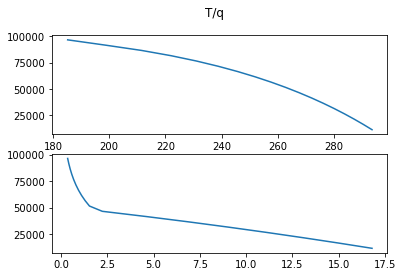

In [203]:
### Constructing vertical profiles ###
## Read in SCAM IOP template here (split into a function at some point)
#plevs = np.array([10, 20, 100, 150, 200, 300, 400, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 975, 1000])
#plevs = np.arange(10,1000,10)


## Convert trop theta values into temperature given plevs ##
plevs = iop_in['lev']

nplevs = np.size(plevs)
ps = 101500. # psurf [pa]
p0 = 100000. # pref [pa]

## Z of plevels, tricky don't have T yet ##
dp_levs = np.diff(plevs)


##### Construct profile ICs #######

## 1. Grab CASE values ##
pblh =  vval[vname.index('pblh')]

the_ft = vval[vname.index('the_trop')]
the_bl = vval[vname.index('the_bl')]
dthedp_ft =  vval[vname.index('the_lr')]

q_ft = vval[vname.index('q_trop')]
q_bl = vval[vname.index('q_bl')]
dqdp_ft = vval[vname.index('q_lr')]



## 2. Find PBL top level ##

# Temperature profile based just on the_bl
t_bl = the_bl*(plevs/p0)**r_cp  

# Assumed t is just below 800mb
p_bl_top = 80000. # hpa estimate pf PBL top.
t_bl_ave = np.average(t_bl[np.where(plevs >= p_bl_top)])

# Z levels based on t_bl
z_plevs = (r_gas/grav)*t_bl*np.log(ps/plevs)

# Where's the PBL?
ipbl_levs = np.where(z_plevs <= pblh)
npbl_levs = np.size(ipbl_levs)
nft_levs = nplevs-npbl_levs

ipbl_min = np.amin(ipbl_levs)


## 3. Use Gradient+mean and specified theta, q for profiles ##

q_plevs = np.full(nplevs, q_bl)
the = np.full(nplevs, the_bl) # Initialize theta pbl as numpys

# Construct profiles in the FT, starting at ipbl+ and working up

for ip in range(ipbl_min-1,-1,-1):
#    print("LEV --> ",ip,plevs[ip].data)
    
    # Temp profile
    t_ip = the[ip-1]*(plevs[ip-1]/p0)**r_cp # Temp at the level below
    rho = plevs[ip]/(r_gas*t_ip)  # Density at lev-=ip
    dz = dp_levs[ip]/(rho*grav)
    the[ip] = the[ip+1]+dthedp_ft*dz

#    print("T ->",t_ip.data,rho.data,dz.data,the[ip])
    
    # q profile 
 
    q_plevs[ip] = q_plevs[ip+1]+dqdp_ft*dz

#    print("q ->",q_plevs[ip],dz.data,dqdp_ft*dz.data)
#    print("")

## Set temp
temp_plevs = the*(plevs/p0)**r_cp

## Don't let q go below a minimum, or tail the value expoentially
#q_plevs[np.where(q_plevs <= 0)] = 0.1
## 
ip0 = np.where(q_plevs <= 0)
ip0m = np.max(ip0)+1
#ip0 = np.append(ip0,ip0m)

print(ip0)

ew = np.exp((plevs[ip0m]-plevs[ip0])/plevs[ip0m]) # Exponetial weights
print(ew)      
ew = (ew[::-1]/np.exp([1]))**2

print(ew)
#print(q_plevs[ip0m])
q_plevs[ip0] = q_plevs[ip0m]*ew


### Set height invarient quantities ##    
print(q_plevs)
    
## Quick plots ##

fig1,axs = mp.subplots(2)
fig1.suptitle('T/q')
axs[0].plot(temp_plevs, plevs[::-1])
axs[1].plot(q_plevs, plevs[::-1])

#z_plevs = (r_gas/grav)*np.mean(temp_plevs)*np.log(ps/plevs)

In [204]:
## Write out data to 4d array, just copying initial temp to all times ##

t = np.copy(var_4d)  
for it in range(0, ntsteps-1):
   t[it,:,0,0] = temp_plevs.data[:]
iop_out['T'] = (iop_out_c4, t)

q = np.copy(var_4d) 
for it in range(0, ntsteps-1):
   q[it,:,0,0] = q_plevs.data[:]
iop_out['Q'] = (iop_out_c4, q)

q = np.copy(var_4d) 
for it in range(0, ntsteps-1):
   q[it,:,0,0] = q_plevs.data[:]
iop_out['Q'] = (iop_out_c4, q)

#print(q_plevs)
iop_out

<xarray.Dataset>
Dimensions:  (lat: 1, lev: 18, lon: 1, time: 504)
Coordinates:
  * lon      (lon) float64 -87.15
  * lat      (lat) float64 32.5
  * lev      (lev) float32 11500.0 16500.0 21500.0 ... 86500.0 91500.0 96500.0
    tsec     (time) int64 43200 45000 46800 48600 ... 945000 946800 948600
Dimensions without coordinates: time
Data variables:
    shflx    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lhflx    (time, lat, lon) float64 0.0 0.000935 0.00187 ... 0.00187 0.000935
    T        (time, lev, lat, lon) float64 185.2 198.6 211.5 ... 0.0 0.0 0.0
    Q        (time, lev, lat, lon) float64 0.3545 0.4171 0.4907 ... 0.0 0.0 0.0
Attributes:
    title:                     arm0795_ebbr.nc
    history:                   Tue Jul  3 11:53:49 2018: ncap2 -O -s tsec($ti...
    missing_value:             -9999.0
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....